In [1]:
import numpy as np
import simpleaudio as sa
import itertools as itt
import matplotlib.pyplot as plt

In [2]:
## Right rotation (negative rotations = left rotations).
## There are 12 chromatic notes in an octave, so we'll use width=12 everywhere.
def ror(n, rotations, width):
    return (2**width - 1) & ((n >> (rotations % width) | n << (width - (rotations % width))))

In [3]:
def bpm_to_step_length(bpm):
    return 60.0 / bpm / 4

In [24]:
# Generate the positions of the ON events in the euclidean sequence
def euclidean_indices(nb_steps, nb_events, nb_shadow_steps=0, rotation=0):
    eucl_idx = [(int(k * (nb_steps + nb_shadow_steps) / nb_events) + rotation) % nb_steps for k in range(nb_events)]
    return eucl_idx

# Transform the set of indices into a series of 1's (events) and 0's (silences)
def euclidean_events(nb_steps, nb_events, nb_shadow_steps=0, rotation=0):
    steps = [0]*nb_steps
    
    eucl_idx = euclidean_indices(nb_steps, nb_events, nb_shadow_steps, rotation)
    eucl_idx = filter(lambda x: x < nb_steps, eucl_idx)
    
    for i in eucl_idx:
        steps[i] = 1

    return steps

# Return a visual representation of the euclidean sequence
def euclidean_string(nb_steps, nb_events, nb_shadow_steps=0, rotation=0):
    eucl_beats = euclidean_events(nb_steps, nb_events, nb_shadow_steps, rotation)
    return ''.join(['o' if x else '.' for x in eucl_beats])

### Print the 16 canonical Euclidean sequences. Notes are played on the o's, silences on the dots.

In [25]:
for k in range(1, 17):
    print(f'{k:>2} events   {euclidean_string(16, k, 0)}')

 1 events   o...............
 2 events   o.......o.......
 3 events   o....o....o.....
 4 events   o...o...o...o...
 5 events   o..o..o..o..o...
 6 events   o.o..o..o.o..o..
 7 events   o.o.o.o..o.o.o..
 8 events   o.o.o.o.o.o.o.o.
 9 events   oo.o.o.oo.o.o.o.
10 events   oo.oo.o.oo.oo.o.
11 events   ooo.oo.oo.oo.oo.
12 events   ooo.ooo.ooo.ooo.
13 events   ooooo.oooo.oooo.
14 events   ooooooo.ooooooo.
15 events   ooooooooooooooo.
16 events   oooooooooooooooo


### Shadow steps allow the generation of non-canonical sequences
#### I don't know anyone using this tweak. Here are the sequences with nb_shadow_steps=7. When using shadow steps we do necessarily have nb_events equal to the actual number of events in the sequence because the position are sometimes bigger than nb_steps-1

In [26]:
for k in range(1, 17):
    print(euclidean_string(16, k))
    print(euclidean_string(16, k, nb_shadow_steps=7))
    print()

o...............
o...............

o.......o.......
o..........o....

o....o....o.....
o......o.......o

o...o...o...o...
oo...o.....o....

o..o..o..o..o...
o.o.o....o...o..

o.o..o..o.o..o..
o..o...o...o...o

o.o.o.o..o.o.o..
o..o..o..o...o..

o.o.o.o.o.o.o.o.
ooo.oo..o..o..o.

oo.o.o.oo.o.o.o.
ooo.oo.o..o.o..o

oo.oo.o.oo.oo.o.
o.o.o.o..o.o.o..

ooo.oo.oo.oo.oo.
o.o.o.o.o.o.o.o.

ooo.ooo.ooo.ooo.
oo.o.o.o.o.o.o.o

ooooo.oooo.oooo.
oo.o.o.oo.o.o.oo

ooooooo.ooooooo.
ooooooo.oo.o.oo.

ooooooooooooooo.
oooooooo.oo.oo.o

oooooooooooooooo
ooo.oo.oo.ooo.oo



##### There are some redundancies because sometimes ```k * nb_steps / 16 = k' * (nb_steps + nb_shadow_steps)/16``` for some k', but there are also novel sequences that are not part of the canonical ones.
##### For example, with nb_shadow_steps=7 there are 13 novel sequences

In [7]:
canonical_seqs = set([euclidean_string(16, k) for k in range(1, 17)])

nb_shadow_steps = 7
seqs_with_shadow = set([euclidean_string(16, k, nb_shadow_steps) for k in range(1, 17)])

# Which sequences are novel (non-canonical)
seqs_with_shadow - canonical_seqs

{'o..........o....',
 'o......o.......o',
 'o..o...o...o...o',
 'o..o..o..o...o..',
 'o.o.o....o...o..',
 'oo...o.....o....',
 'oo.o.o.o.o.o.o.o',
 'oo.o.o.oo.o.o.oo',
 'ooo.oo..o..o..o.',
 'ooo.oo.o..o.o..o',
 'ooo.oo.oo.ooo.oo',
 'ooooooo.oo.o.oo.',
 'oooooooo.oo.oo.o'}

#### Varying nb_shadow_steps going from 0 to 15 wer generate a total of 152 different sequences, 136 of which are non-canonical. We do not generate any novel sequences by setting nb_shadow_steps > 15. We haven't checked if there's a easy relation between the two.

In [27]:
all_seqs = set([euclidean_string(16, k, sh) for k in range(1, 17) for sh in range(16)])
len(all_seqs)

152

In [34]:
# calculate note frequencies
A_freq = 440
## Frequencies from C0 at index 0 to C8 at index 96 = 8 * 12
NOTE_FREQUENCIES = A_freq * 2 ** ((np.arange(-8, 89) - 49)/12)

# In the arduino code we encode scales 
# in the first 12 bits of an int16
# We read the scale from right to left
# The root is at the LSB position (and always 1, of course)
# This method allows us to easily generate the note used
# in a scale regardless of the root

# Here are some examples
CHROMATIC = 0b111111111111
MAJOR = 0b101010110101
MINOR = 0b010110101101
MAJOR_PENTATONIC = 0b001010010101
MINOR_PENTATONIC = 0b010010101001
BLUES = 0b010011101001
JAPANESE = 0b000110001101
FREYGISH = 0b010110110011
ROMANI = 0b100111001101
SCOTTISH = 0b001010100101
ARABIC = 0b100110110011

In [35]:
# Root indices are the same as https://en.wikipedia.org/wiki/Piano_key_frequencies
# C0 is at 0 and C8 is at 96

# low and high specify the boundaries of the note indices 
# in the scale relative to the root. They are not indexes to any kind of array

# e.g. low=-1, high=5 mean that we go from one note below the root 
#      to 5 notes above the root for a total of 7 notes
# root=48 is C4
#
# This is tricky and the code kinda ugly because low/high are in the scale
# but we must return a set of indices for NOTE_FREQUENCIES
def note_indices_in_scale(scale, root=48, low=None, high=None):
    nb_notes_in_scale = sum(ror(scale, i, 12) & 1 for i in range(12))
    if low is None:
        low = 0 # Start at root note when low is left unspecified
    if high is None:
        high = low + nb_notes_in_scale # Stop one octave above the low when high left unspecified

    if high < low:
        return []
    
    nb_notes = high - low + 1
    
    notes = []

    temp_scale = scale
    index = root
    inscale_idx = 0
    if low < 0:
        while inscale_idx > low:
            index -= 1
            if index < 0: 
                index = 0
                break
            temp_scale = ror(temp_scale, -1, 12)
            Qinscale = temp_scale & 1
            inscale_idx -= Qinscale

    elif low >= 0:
        while inscale_idx < low:
            index += 1
            if index >= len(NOTE_FREQUENCIES): 
                index = len(NOTE_FREQUENCIES) - 1
                break
            temp_scale = ror(temp_scale, 1, 12)           
            Qinscale = temp_scale & 1
            inscale_idx += Qinscale

#     print(f'{inscale_idx}, {index}, {temp_scale:>012b}')
    
    indices = []
    while inscale_idx <= high:
        Qinscale = temp_scale & 1
        if Qinscale:
            inscale_idx += 1
            indices.append(index)
        index += 1
        if index >= len(NOTE_FREQUENCIES): break
        temp_scale = ror(temp_scale, 1, 12)
            
    return indices

In [45]:
# The root is the first element of the returned array
print(f'Chromatic, notes spanning one octave:\n{note_indices_in_scale(CHROMATIC, root=37, low=0, high=12)}\n')

# The root note is at the third element
print(f'Minor with 2 notes below the root and 5 above:\n{note_indices_in_scale(MINOR, root=12, low=-2, high=5)}\n') 

print(f'Major pentatonic:\n{note_indices_in_scale(MAJOR_PENTATONIC, root=48, low=-5, high=5)}\n')

print(f'Major pentatonic with unrealistic low/high notes:\n{note_indices_in_scale(MAJOR_PENTATONIC, root=48, low=-500, high=500)}\n')

Chromatic, notes spanning one octave:
[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Minor with 2 notes below the root and 5 above:
[8, 10, 12, 14, 15, 17, 19, 20]

Major pentatonic:
[36, 38, 40, 43, 45, 48, 50, 52, 55, 57, 60]

Major pentatonic with unrealistic low/high notes:
[0, 2, 4, 7, 9, 12, 14, 16, 19, 21, 24, 26, 28, 31, 33, 36, 38, 40, 43, 45, 48, 50, 52, 55, 57, 60, 62, 64, 67, 69, 72, 74, 76, 79, 81, 84, 86, 88, 91, 93, 96]



In [46]:
# The Markov transition matrix encodes the transition probability from
# one note (state) to the next. If one is in the state 4 (which correspond to some note),
# then we look at the 4th column to find the probabilities or transitioning to states 0 to n-1
# where n is the total number of notes returned by note_indices_in_scale().
# Each columns sums to 1 because they are transition probabilities spanning all possible states

def generate_markov_matrix(low, high, scale_dispersion=3, first_neighbor=1.0, second_neighbor=1.0, jump_to_root=1.0, repeat_note=1.0, seed=None):
    if type(seed) == np.random.RandomState:
        rng = seed
    else:
        rng = np.random.RandomState(seed)

    markov_matrix = rng.uniform(size=(high - low + 1, high - low + 1))

    width = high - low + 1
    dist_to_diag = np.abs(np.arange(width)[None, :] - np.arange(width)[:, None])
    
    # Cauchy kernel with characteristic width given by scape_dispersion
    markov_matrix /= np.pi * scale_dispersion * (1 + (dist_to_diag / scale_dispersion)**2)
    # First neighbors reweighting
    markov_matrix *= first_neighbor * (dist_to_diag == 1).astype(float) + (dist_to_diag != 1).astype(float)
    # Second neighbors reweighting
    markov_matrix *= second_neighbor * (dist_to_diag == 2).astype(float) + (dist_to_diag != 2).astype(float)
    # Jump to root reweigthing
    if low <= 0:
        markov_matrix[-low, :] *= jump_to_root
    # Repeat note reweighting
    markov_matrix[np.diag_indices_from(markov_matrix)] *= repeat_note
    
    # Normalize columns to make them transition probabilities
    markov_matrix /= markov_matrix.sum(axis=0, keepdims=True)
    
    return markov_matrix

Text(0, 0.5, 'Next note')

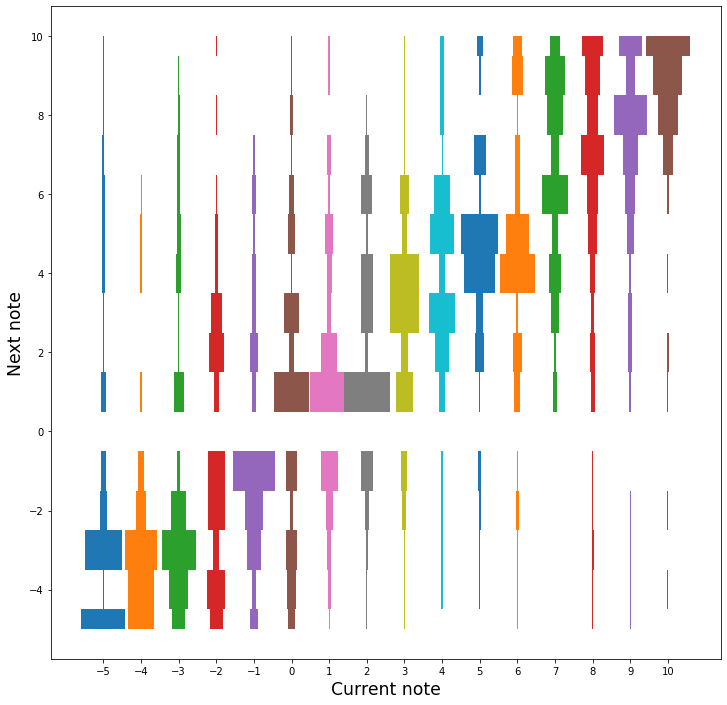

In [55]:
# Visual representation of the Markov matrix. As you can see the probability
# of jumping to far-away notes decreases on average and is dictated by scale_dispersion
# We set jump_to_root=0 and you can see that the probabilities associated with jumping
# from any of the note to the root is empty.
# We labeled the x and y axis from low=-5 to high=10, but the underlying states are indices
# from 0 (equivalent to low) to 16 (equivalent to high), passing through 5 (the root).

low, high = -5, 10
mm = generate_markov_matrix(low, high, scale_dispersion=2, jump_to_root=0.0, repeat_note=1.0, seed=3)

plt.figure(figsize=(12, 12))
w = 3
plt.xticks(range(low, high + 1))
for i, column in zip(range(low, high + 1), mm.T):
    plt.fill_betweenx(range(low, high + 1), i + w*column/2, i - w*column/2, step='mid')
plt.xlabel('Current note', fontsize='xx-large')
plt.ylabel('Next note', fontsize='xx-large')

In [14]:
def generate_sine_waveform(note, T, attack=0.1, decay=0.1, sample_rate=8000, bits=8):
    note = max(min(note, len(NOTE_FREQUENCIES) - 1), 0)
    freq = NOTE_FREQUENCIES[note]
    t = np.linspace(0, T, int(T * sample_rate), endpoint=False)
    
    waveform = np.sin(freq * t * 2 * np.pi)
    
#     waveform = np.sign(waveform)
    
    if attack > 0.0:
        waveform[:int(len(waveform) * attack)] *= np.linspace(0.0, 1.0, int(len(waveform) * attack), endpoint=True)
    
    if decay > 0.0:
        waveform[-int(len(waveform) * decay):] *= np.linspace(1.0, 0.0, int(len(waveform) * decay), endpoint=True)
    
    # Quantize
    waveform *= (2**(bits - 1) - 1) / max(np.abs(waveform))
    waveform = waveform.astype(np.int8)
    
    return waveform

def generate_silence(T, sample_rate=8000):
    return np.zeros(int(T * sample_rate)).astype(np.int8)

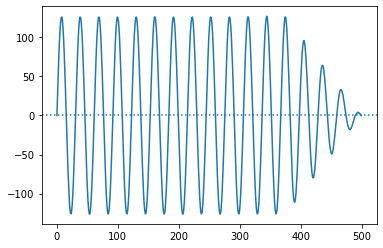

In [15]:
plt.plot(generate_sine_waveform(48, 1/16, attack=0.0, decay=0.25))
plt.axhline(0, ls='dotted')

In [16]:
# The state is not a note but an index in the the array of notes returned by note_indices_in_scale()
def next_state(state, markov_matrix, rng):
    width = markov_matrix.shape[0]
    return rng.choice(width, p=markov_matrix[:, state])

def note_generator(initial_state, markov_matrix, note_indices_array, rng):
    state = initial_state
    assert 0 <= initial_state < markov_matrix.shape[0]
    
    while True:
        yield note_indices_array[state]
        state = next_state(state, markov_matrix, rng)


In [17]:
bin(MAJOR_PENTATONIC)

'0b1010010101'

In [18]:
# The root is an absolute index (C0 = 0, C1 = 12, ..., G4=55, ...)
# low_note, high_note, are relative to the root
# e.g. root = 0, in the major scale 7 is one octave above the root,
#      in a pentatonic scale 5 is one octave above the root,
#      and in the chromatic scale 12 is one octave above the root.
# finally first_state is relative to the indices of the markov matrix
# so first_state=0 means the first note is low_note
# and say first_state=3 would be the root if low_note=-3.

def generate_bassline_audio(scale, root, low_note, high_note, first_state, 
                            bpm, nb_bars, repeat_bars, 
                            euclidean_parameters, markov_parameters, 
                            markov_matrix_seed, note_transitions_seed):
    

    nb_steps = euclidean_parameters['nb_steps']    
    
    eucl_seq = euclidean_events(**euclidean_parameters) #nb_steps, nb_events, nb_shadow_steps, rotation)
    print('Euclidean sequence')
    print(euclidean_string(**euclidean_parameters))
    print()
    
    markov_matrix = generate_markov_matrix(low=low_note, high=high_note, seed=markov_matrix_seed, **markov_parameters)
#                                 scale_dispersion=5.5, 
#                                 first_neighbor=3.0,
#                                 second_neighbor=1.0,
#                                 jump_to_root=1.3, 
#                                 repeat_note=1.0,
#                                 seed=markov_matrix_seed)


    T = bpm_to_step_length(bpm)
    
    niis = note_indices_in_scale(scale, root=root, low=low_note, high=high_note)

    if not repeat_bars:
        note_rng = np.random.RandomState(seed=note_transitions_seed)
        note_gen = note_generator(first_state, markov_matrix, niis, note_rng)

    audio = np.array([]).astype(np.int8)
    
    print('Notes of the Markov chain')
    for _ in range(nb_bars):
        
        if repeat_bars:
            note_rng = np.random.RandomState(seed=note_transitions_seed)
            note_gen = note_generator(first_state, markov_matrix, niis, note_rng)
            
        for i in range(nb_steps):
            playQ = eucl_seq[i % nb_steps]
            if playQ:
                note = next(note_gen)
                print(f'|{note}|', end='', flush=True)
                waveform = generate_sine_waveform(note, T, attack=0.1, decay=0.1, sample_rate=8000, bits=8)
            else:
                print('.', end='', flush=True)
                waveform = generate_silence(T, sample_rate=8000)
            audio = np.hstack((audio, waveform))
        print(end='\n', flush=True)
        
    return audio

Euclidean sequence
o.o.o.oo.o.o.ooo

Notes of the Markov chain
|24|.|34|.|36|.|41||46|.|43|.|46|.|48||48||36|
|36|.|43|.|41|.|43||39|.|36|.|34|.|36||41||43|
|36|.|34|.|36|.|41||46|.|36|.|41|.|43||27||34|
|36|.|34|.|48|.|48||43|.|48|.|43|.|41||46||48|


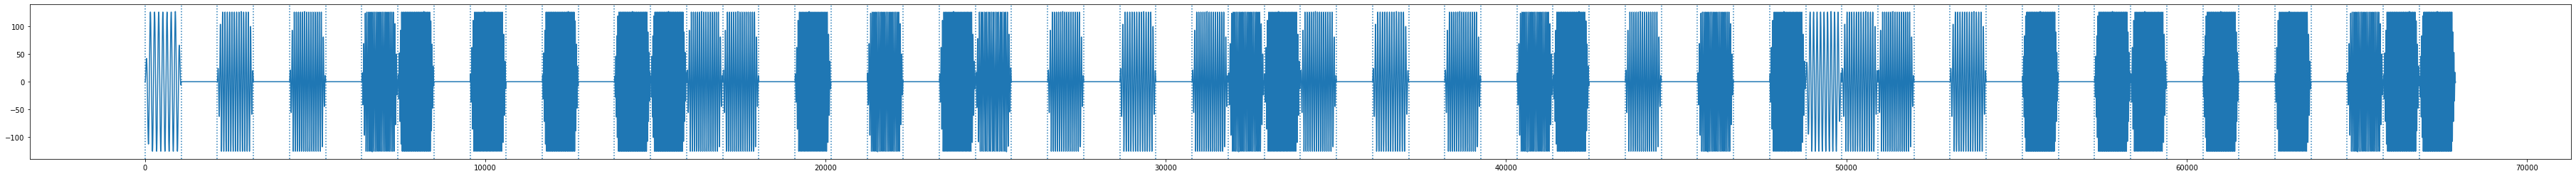

In [20]:
euclidean_parameters = {'nb_steps':16,
                        'nb_events': 13,
                        'nb_shadow_steps':7,
                        'rotation':-1
                        }

markov_parameters = {'scale_dispersion':4.0,
                     'first_neighbor':3.0,
                     'second_neighbor':2.0,
                     'jump_to_root':1.3, 
                     'repeat_note':1.0
                    }

bpm = 113

audio = generate_bassline_audio(MINOR_PENTATONIC, root=36, low_note=-5, high_note=5, first_state=0, 
                                bpm=bpm, nb_bars=4, repeat_bars=False,
                                euclidean_parameters=euclidean_parameters, markov_parameters=markov_parameters,
                                markov_matrix_seed=433, note_transitions_seed=450)

plt.figure(figsize=(64, 4))
plt.plot(audio)
for x in range(0, len(audio), int(bpm_to_step_length(bpm) * 8000)):
    plt.axvline(x, ls='dotted')
plt.show()

    
play_obj = sa.play_buffer(audio, 1, 1, 8000)
play_obj.wait_done()